<DIV ALIGN=CENTER>

# Introduction to Text Mining, Part II
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we continue our work from the previous
Notebook on text data mining. We now focus on different classification
algorithms, before introducing the concept of using token frequency,
normalized by its frequency over the document collection as a
classification technique. Finally we introduce pipelining before
discussing some more advanced concepts in text data mining.

-----

### Initialize Notebook

Before we begin, we must repopulate this Notebook with both the necessary
data and supporting functions.

-----

In [1]:
# load dataset
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(data_home='/home/data_scientist/data/textdm', subset='train', shuffle=True, random_state=23)
test = fetch_20newsgroups(data_home='/home/data_scientist/data/textdm', subset='test', shuffle=True, random_state=23)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

# Verify attributes

cv = CountVectorizer(stop_words = 'english', ngram_range=(1,2), max_features=100000)
train_counts = cv.fit_transform(train['data'])
test_data = cv.transform(test['data'])


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", context='paper', font='monospace')

# Convenience function to plot confusion matrix

# This method produces a colored heatmap that displays the relationship
# between predicted and actual types from a machine leanring method.

def confusion(test, predict, title):

    f, ax = plt.subplots(figsize=(12, 8))

    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins=20)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int))
    
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title(title)
    
    return None

-----

## Document Classification

We now look at more advanced classification techniques than the Naive
Bayes classification technique that we employed in the previous Notebook.

### Linear SVM Classifier

One of the simplest classification techniques to understand is [support
vector machine][svmd], or SVM. SVM attempts to divide data by finding
(hyper-)planes that optimally differentiate data between classes. For
our text data mining, we can employ linear SVM for classification, known
as linear SVC, to classify text documents by their token feature
vectors. scikit_learn implements this technique in the [`LinearSVC`][lsvc] class.

-----
[lsvc]: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

[svmd]: https://en.wikipedia.org/wiki/Support_vector_machine

In [4]:
# Next lets try Linear SVM
from sklearn import svm

# Lets build our model and train it all at once

clf = svm.LinearSVC(C=1000).fit(train_counts, train['target'])

predicted = clf.predict(test_data)

In [5]:
print("SVM prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test_data, test['target'])))

SVM prediction accuracy =  80.0%


In [6]:
from sklearn import metrics

print(metrics.classification_report(test['target'], predicted,
    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.73      0.76       319
           comp.graphics       0.68      0.74      0.71       389
 comp.os.ms-windows.misc       0.72      0.69      0.71       394
comp.sys.ibm.pc.hardware       0.63      0.67      0.65       392
   comp.sys.mac.hardware       0.74      0.78      0.76       385
          comp.windows.x       0.81      0.72      0.76       395
            misc.forsale       0.75      0.86      0.80       390
               rec.autos       0.85      0.83      0.84       396
         rec.motorcycles       0.89      0.92      0.91       398
      rec.sport.baseball       0.86      0.88      0.87       397
        rec.sport.hockey       0.92      0.94      0.93       399
               sci.crypt       0.93      0.91      0.92       396
         sci.electronics       0.69      0.71      0.70       393
                 sci.med       0.85      0.80      0.82       396
         

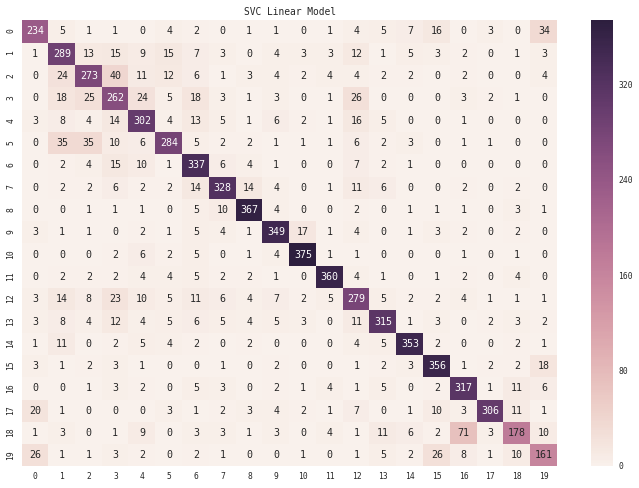

In [7]:
confusion(test['target'], predicted, 'SVC Linear Model')

-----

### SVM with SGD

We can use a [modified linear SVM][sgd] classifier that employs stochastic gradient
descent to quantify the loss for each sample, which is used to update
the classification model. Note for best results, we want our data to
have zero mean and unit variance for this technique to optimally work.
Since out text dta do not have this, we should expect suboptimal results.

-----
[sgd]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [8]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier().fit(train_counts, train['target'])
predicted = clf.predict(test_data)

print("SVM prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test_data, test['target'])))

# Can verify with following code
# np.mean(predicted == test['target'])   


SVM prediction accuracy =  76.5%


In [9]:
print(metrics.classification_report(test['target'], predicted,
    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.80      0.70      0.75       319
           comp.graphics       0.69      0.71      0.70       389
 comp.os.ms-windows.misc       0.74      0.62      0.68       394
comp.sys.ibm.pc.hardware       0.58      0.67      0.63       392
   comp.sys.mac.hardware       0.80      0.70      0.75       385
          comp.windows.x       0.85      0.71      0.77       395
            misc.forsale       0.75      0.81      0.78       390
               rec.autos       0.72      0.81      0.76       396
         rec.motorcycles       0.70      0.93      0.80       398
      rec.sport.baseball       0.82      0.86      0.84       397
        rec.sport.hockey       0.90      0.93      0.91       399
               sci.crypt       0.90      0.84      0.87       396
         sci.electronics       0.57      0.70      0.63       393
                 sci.med       0.84      0.70      0.76       396
         

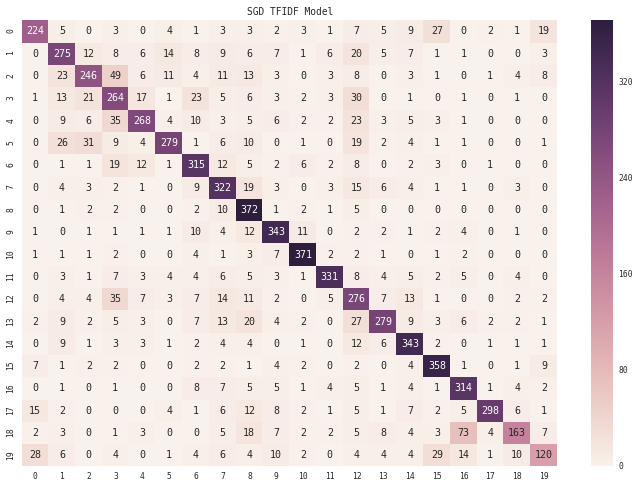

In [10]:
confusion(test['target'], predicted, 'SGD TFIDF Model')

----

### Logistic Regression

[Logistic Regression][lrd] is typically employed on categorical
variables, such as yes/no decision, or win/loss likelihoods. In the case
of many labels, we can use the trick that logistic regressin can
quantify the likelihood a vector is in or out of a particular category.
Thus, by computing this over all categories we can determine the best
label for each test vector. [scikit_learn][sllr] provides an
implementation that can be easily used for our classification problem

-----

[lrd]: https://en.wikipedia.org/wiki/Logistic_regression
[sllr]: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1000)
clf.fit(train_counts, train['target'])

print("SVM prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test_data, test['target'])))

predicted = clf.predict(test_data)

SVM prediction accuracy =  81.5%


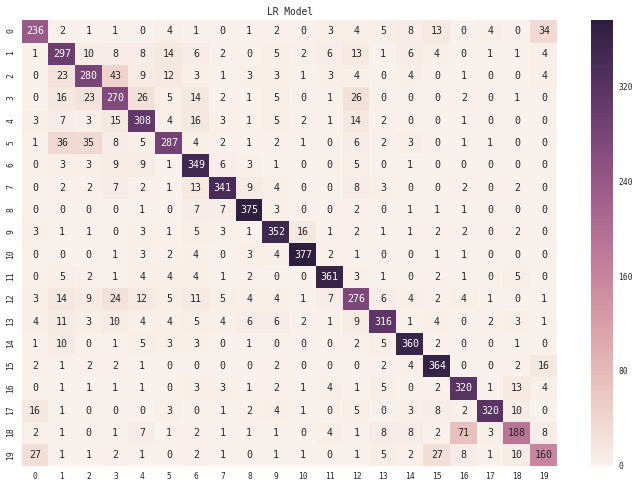

In [12]:
confusion(test['target'], predicted, 'LR Model')

In [13]:
# This code cell demonstrates using different penalty functions (e.g., lasso or ridge) 
# with Logistic Regression on our sample data.

# clf = LogisticRegression(C = 1000, penalty='l1')
# clf = LogisticRegression(C = 1000, penalty='l2')

# clf.fit(train_counts, train['target'])

# print("LR-1 prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test_data, test['target'])))
# print("LR-2 prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test_data, test['target'])))

# predicted = clf.predict(test_data)

----

### TF IFD

Previously, we have simply used the number of times a token (i.e., word,
or more generally an n-gram) occurs in a document to classify the
document. Even with the removal of stop words, however, this can still
overemphasize tokens that might generally occur across many documents
(e.g., names or general concepts). An alternative technique that often
provides robust improvements in classification accuracy is to employ the
frequency of token occurrence, normalized over the frequency with which
the token occurs in all documents. In this manner, we give higher
weight in the classification process to tokens that are more strongly
tied to a particular label. 

Formally this concept is known as [term frequency–inverse document
frequency][tfd] (or tf-idf), and scikit-learn provides this
functionality via the [`TfidfTransformer`][tftd] that can either follow
a tokenizer, such as `CountVectorizer` or can be combined together into
a single transformer via the [`TfidfVectorizer`][tfvd]

-----
[tfd]: https://en.wikipedia.org/wiki/Tf–idf

[tftd]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

[tfvd]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_counts)
train_tfidf.shape

(11314, 100000)

In [15]:
clf = SGDClassifier().fit(train_tfidf, train['target'])

test_tfidf_data = tfidf_transformer.transform(test_data)

print("SGD TF-IDF prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test_tfidf_data, test['target'])))

predicted = clf.predict(test_tfidf_data)

SGD TF-IDF prediction accuracy =  85.0%


In [16]:
print(metrics.classification_report(test['target'], predicted,
    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.83      0.78      0.81       319
           comp.graphics       0.76      0.78      0.77       389
 comp.os.ms-windows.misc       0.77      0.74      0.75       394
comp.sys.ibm.pc.hardware       0.73      0.72      0.73       392
   comp.sys.mac.hardware       0.83      0.86      0.84       385
          comp.windows.x       0.86      0.78      0.82       395
            misc.forsale       0.82      0.90      0.86       390
               rec.autos       0.91      0.89      0.90       396
         rec.motorcycles       0.93      0.95      0.94       398
      rec.sport.baseball       0.90      0.95      0.92       397
        rec.sport.hockey       0.95      0.97      0.96       399
               sci.crypt       0.92      0.94      0.93       396
         sci.electronics       0.80      0.75      0.77       393
                 sci.med       0.90      0.88      0.89       396
         

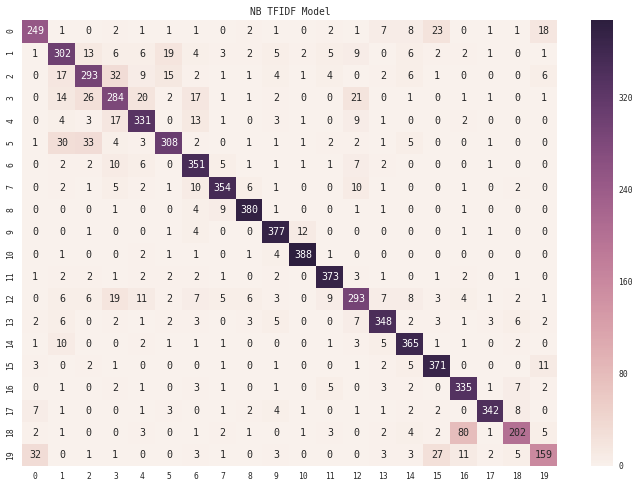

In [17]:
confusion(test['target'], predicted, 'NB TFIDF Model')

### Tweet Data 

We can repeat the Tweet analysis from the previous Notebook, but this time by using TF-IDF. 

In [18]:
docs_new = [
    '''Are you an Entrepreneur at the University of Illinois in Champaign ? 
    If so, you will want to look at this. See=&gt; https://t.co/TVMxlEdo9d''',
    '''@YoureWelcomeCU highlights tech innovation from #ChampaignUrbana and much more:
    http://t.co/CXIbpNL3UH http://t.co/y3am3swGKU''',
    '''RT @LauraFrerichs: Tim Hassinger, CEO of @DowAgro at grand opening of new Innovation Lab
    @UIResearchPark "it's a special relationship" http…''',
    '''Join us on October 6 for Data Analytics After Hours: #networking event w/local companies
    http://t.co/fJfOa0U3tS http://t.co/23F0sDYhQN'''
]


new_counts = cv.transform(docs_new)
test_tfidf_data = tfidf_transformer.transform(new_counts)

clf = SGDClassifier().fit(train_tfidf, train['target'])
predicted = clf.predict(test_tfidf_data)


for doc, category in zip(docs_new, predicted):
    print('{0} \n=> {1}\n'.format(doc, train['target_names'][category]))

Are you an Entrepreneur at the University of Illinois in Champaign ? 
    If so, you will want to look at this. See=&gt; https://t.co/TVMxlEdo9d 
=> rec.autos

@YoureWelcomeCU highlights tech innovation from #ChampaignUrbana and much more:
    http://t.co/CXIbpNL3UH http://t.co/y3am3swGKU 
=> comp.sys.ibm.pc.hardware

RT @LauraFrerichs: Tim Hassinger, CEO of @DowAgro at grand opening of new Innovation Lab
    @UIResearchPark "it's a special relationship" http… 
=> soc.religion.christian

Join us on October 6 for Data Analytics After Hours: #networking event w/local companies
    http://t.co/fJfOa0U3tS http://t.co/23F0sDYhQN 
=> sci.space



-----

### Pipeline

scikit\_learn suports the concept of _pipelines_ where the output of one
step in the classification process is connected to the input of another
step. For example, we can connect the tokenizer to the TF\_IDF
transformer, followed by a classifier. While this can make a text data
mining application easier to read and understand, it can also be faster
since the scikit_learn library can enable optimizations since it
controls the process of defining, initializing, and running a pipeline.

-----

In [19]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=23))])

In [20]:
text_clf = text_clf.fit(train['data'], train['target'])

In [21]:
predicted = text_clf.predict(test['data'])

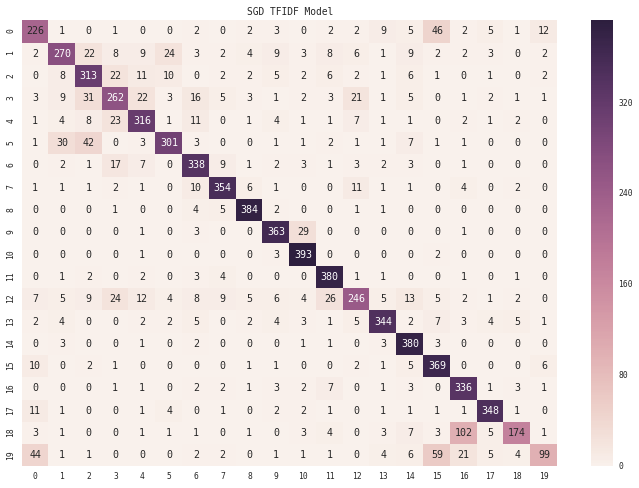

In [22]:
confusion(test['target'], predicted, 'SGD TFIDF Model')

-----

### Tweet Data Test

We can reexamine the classification of our selected tweets by now using
the text classification pipeline, that now employs TF-IDF in the
classification process.

-----

In [23]:
# Classify tweets with new pipeline

predicted = text_clf.predict(docs_new)

for doc, category in zip(docs_new, predicted):
    print('{0} \n=> {1}\n'.format(doc, train['target_names'][category]))

Are you an Entrepreneur at the University of Illinois in Champaign ? 
    If so, you will want to look at this. See=&gt; https://t.co/TVMxlEdo9d 
=> rec.autos

@YoureWelcomeCU highlights tech innovation from #ChampaignUrbana and much more:
    http://t.co/CXIbpNL3UH http://t.co/y3am3swGKU 
=> comp.windows.x

RT @LauraFrerichs: Tim Hassinger, CEO of @DowAgro at grand opening of new Innovation Lab
    @UIResearchPark "it's a special relationship" http… 
=> talk.politics.mideast

Join us on October 6 for Data Analytics After Hours: #networking event w/local companies
    http://t.co/fJfOa0U3tS http://t.co/23F0sDYhQN 
=> comp.windows.x



### Clustering Analysis

We can also apply clustering analysis to our feature matrix. While
finding an unknown number of clusters in text documents can be
difficult, we can learn about our data by identifying the clusters for
our **known** labels. TO demonstrate, in the following code cells, we
employ k-means to find twenty clusters in our feature matrix, after
which we identify the most frequently used words in each cluster.

-----

In [24]:
from sklearn.cluster import KMeans

true_k = 20

km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

km.fit(test_data)

KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [25]:
labels = test['target']

print("Top 10 tokens per cluster:\n")

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()

for i in range(true_k):
    print("Cluster {0}:".format(i), end='')
    for ind in order_centroids[i, :10]:
        print(' {0}'.format(terms[ind]), end='')
    print('\n')

Top 10 tokens per cluster:

Cluster 0: edu file com ftp image use server available gopher graphics

Cluster 1: edu subject com lines organization writes article university don like

Cluster 2: openwindows use sun xview look usr x11 lib open subject

Cluster 3: god psalms christ lord prayers jesus kingdom church man people

Cluster 4: jpeg image gif file color format images quality version files

Cluster 5: dos dos dos windows microsoft windows microsoft tcp ms mouse amiga software

Cluster 6: 92 12 12 92 10 hiv 17 10 12 11 aids patients

Cluster 7: myers ms myers ms president think don dee ll know said

Cluster 8: 00 20 appears 40 50 art 80 10 wolverine 60

Cluster 9: god theism observations hg does hypothesis coin atheism don probability

Cluster 10: edu graphics pub mail ray 128 send 3d ftp com

Cluster 11: mac files comp disk file software sys comp sys sys mac ftp

Cluster 12: ar armenian pts karabakh azeris armenians azeri armenia azerbaijan conflict

Cluster 13: image data edu ava

## Advanced Concepts

In these two Notebooks, we have introduced many of the fundamental
concepts in text data mining. But there are more advanced concepts, and
recent work that promise even more powerful text data mining
functionality. As one simple example, we can specify a vocabulary when
transforming text documents into a feature matrix. We saw examples where
the number of features was restricted and where n-grams were allowed.
But we also can restrict the vocabulary to n-grams with clear intention,
this can lead to the concept of sentiment analysis. In addition, words
can be mapped within a sentence or document to their grammatical labels,
allowing more powerful learning techniques to be enabled that can lead
to improved language translation or content modelling.

As one example, the following website enables grammar syntax modelling.

-----

In [26]:
from IPython.display import HTML
HTML('<iframe src=http://spacy.io/displacy/ width=800 height=600></iframe>')

-----
## Breakout Session

During this breakout, you should learn more about text data mining. Be
sure to try all code cells in this Notebook.  Specific problems you can
also attempt include the following:

1. Try different combinations f n-grams and maximum number of features
with `LinearSVC` classification.

2. Explore different parameter combinations for `LogisticRegresion`
including the two penalty functions present in a code cell.

Additional, more advanced problems:

1.Build a pipeline that uses TF-IDF, a Hashing Vectorizer, and Logistic
Regression to classify twitter data (look at the twitter notebook from
Week 3 for more guidance on obtaining many tweets.)

-----

### Additional References

3. Another useful library is the [Natual Language ToolKit][nltk].
4. Spark can be used for [text data mining][stdm].

-----

[nltk]: http://www.nltk.org

[stdm]: https://spark.apache.org/examples.html

### Return to the [Week 4 Index](index.ipynb).

-----